# Part 1
Please design and implement a solution to crawl the publication title, year and author list of every unique publication record on the target website. Then, please create and display a table that contains these unique records. The table should consist of five columns: the row number in the table, publication title, year, author list, and the place of publication.

In [15]:
# Importing necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import csv
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
import networkx as nx
from IPython.core.display import display, HTML
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Base URL with variable page number
urlBase = "https://polskiszekspir.uw.edu.pl/items/index/page/{}"

# Empty list for all topic page urls
urlTopics = []

# Function to generate URLs with increasing page numbers
def generate_page_urls(base_url, num_pages):
    for page_num in range(1, num_pages + 1):
        url = base_url.format(page_num)
        urlTopics.append(url)

# Generate URLs for the first 5 pages (you can adjust the number as needed)
generate_page_urls(urlBase, 5)

def extract_publications(soup):
    publications = []

    for publication in soup.find_all('div', class_='item--wrapper'):
        title_unfiltered = publication.find('span', class_='item__translator-title')
        if not title_unfiltered:
            print("Title not found")
            continue
        title_text = title_unfiltered.text.strip()

        # Extracting authors information
        authors = []
        for author_tag in publication.find_all('span', class_='item__translator-name'):
            author_text = author_tag.text.strip()
            # Extract only surname and name without dates
            author_name = re.match(r'([\w\-]+),\s*([\w\-]+)', author_text)
            if author_name:
                surname, name = author_name.groups()
                authors.append(f"{surname}, {name}")
            else:
                print(f"Could not extract author name from: {author_text}")

        # Convert authors list to a string
        authors_str = ', '.join(authors)

        # Extracting year information
        year_element = publication.find("div", class_="item__details--right").find("span", class_="item__details-place__name")
        year = year_element.text.strip() if year_element else None

        # Extracting place of publication
        place_element = publication.find("div", class_="item__details--left").find("span", class_="item__details-place__name")
        place = place_element.text.strip() if place_element else None

        # Extracting publisher
        publisher_element = publication.find_all("div", class_="item__details--left")[1].find("span", class_="item__details-place__name")
        publisher = publisher_element.text.strip() if publisher_element else None

        publications.append({
            "title": title_text,
            "author": authors_str,
            "year": year,
            "place of publication": place,
            "publisher": publisher
        })

    return publications




# Function to display the table with styling
def display_table_enhanced(publications):
    if not publications:
        print("No publications data found.")
        return
    df = pd.DataFrame(publications)
    df = df.drop_duplicates() # deleting duplicate records
    df = df.sort_values(by=['year', 'title'], ascending=[False, True]) # Sorting the entries in the table
    df.index = range(1, len(df) + 1)  # So the first position is no 1., not 0.

    # Improving visual aspects of the table with pandas styling
    styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold')]},  # Bold headers
        {'selector': 'td', 'props': [('text-align', 'left')]},   # Aligning text to the left in text cells
        {'selector': 'th', 'props': [('text-align', 'left')]},   # Aligning text to the left in header cell
    ]).set_properties(**{'background-color': 'white', 'color': 'black'}) # Background colours
    return styled_df

# Collecting all publications from every single topic URL
all_publications = []
for topicUrl in urlTopics:
    print(f"Scraping: {topicUrl}")  # So it is displaying in the output which URL is being scraped right now
    try:
        response = requests.get(topicUrl)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            publications = extract_publications(soup)
            print(f"Found {len(publications)} publications.")
            all_publications.extend(publications)

            # Check if there is a next page link
            next_page_link = soup.find('a', class_='next')
            if next_page_link:
                next_page_num = int(next_page_link['href'].split('/')[-1])  # Extracting the page number from the URL
                next_page_url = urlBase.format(next_page_num)  # Generating the URL for the next page
                urlTopics.append(next_page_url)  # Add next page URL to the list for scraping
        else:
            print(f"Failed to retrieve {topicUrl}, status code {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {topicUrl}, error: {e}")
    time.sleep(1)  # So there is a polite delay between each of the requests

print(f"Total publications found: {len(all_publications)}")

styled_df = display_table_enhanced(all_publications)
styled_df # displaying the table


Scraping: https://polskiszekspir.uw.edu.pl/items/index/page/1
Found 12 publications.
Scraping: https://polskiszekspir.uw.edu.pl/items/index/page/2
Found 12 publications.
Scraping: https://polskiszekspir.uw.edu.pl/items/index/page/3
Found 12 publications.
Scraping: https://polskiszekspir.uw.edu.pl/items/index/page/4
Found 12 publications.
Scraping: https://polskiszekspir.uw.edu.pl/items/index/page/5
Found 12 publications.
Total publications found: 60


,title,author,year,place of publication,publisher
1,Burza,"Dzieduszycki, Wojciech",1904,Kraków,Drukarnia „Czasu”
2,Król Lear,"Dzieduszycki, Wojciech",1904,Kraków,Drukarnia „Czasu”
3,Romeo i Julia,"Dzieduszycki, Wojciech",1904,Kraków,Drukarnia „Czasu”
4,Miarka za miarkę,"Kasprowicz, Jan",1897,Lwów,Księgarnia Polska
5,Jak wam się podoba,"Lange, Antoni",1896,Lwów,Księgarnia Polska
6,Noc Trzech Króli,"Lange, Antoni",1896,Lwów,Księgarnia Polska
7,"Wszystko dobre, co się dobrze kończy","Porębowicz, Edward",1896,Lwów,Księgarnia Polska
8,Burza,"Paszkowski, Józef",1895,Lwów,Księgarnia Polska
9,Figle kobiet,"Paszkowski, Józef",1895,Lwów,Księgarnia Polska
10,Juljusz Cezar,"Pajgert, Adam",1895,Złoczów,Księgarnia Wilhelma Zukerkandla


### Description of the code


This code was implemented taking into consideration handling possible errors, validation and the best visualisation of data from web scraping, also being user-friendly.

I tried to break down the code into specific functions such as "extract_publications", or "display_table_enhanced", so it is much easier to follow and possibly update. Each of the function covers different part of the process of this task, keeping in mind clean code organisation.

In "extract_publications" function I made sure to filter out the unwanted words that were appearing in the title entries, as well as non-author text. It was completed by implementing efficient text processing expressions. I decided to use r library for this purpose.

At the end, in "display_table_enhanced" I am using Pandas library to create a nicely looking styled DataFrame, which displays publications with their yea, names of authors, place of publication and titles.

# Part 2

The Cross-Sectional Asset Pricing dataset includes 210 features. The target variable is 'excessret', a firm's excess return between the current and the previous quarter. You are required to work on a subset that includes the 'defined features' and the 'target variable' by performing preprocessing (in the subset, there will be 11 features in total including target variable). You are required to extract the 'defined features' that are as indicated below:

defined_columns = ['high52', 'mom12m', 'mom6m', 'maxret', 'mom12moffseason', 'realizedvol', 'idiovolaht', 'zerotrade', 'indretbig', 'returnskew']

Design and implement the solution to analyze the complex relationship between defined features and the firm's excess return between the current and the previous quarter. Highlight and visualise the attributes with the highest probabilistic relationship with the target variable. Justify the design choice and showcase the findings using an appropriate visualisation tool.

### Write your code in the following space.

In [ ]:
# Opening the dataset

open('finance_dataset.csv', mode = 'r')  #dataset is already in the .csv format so we don't need to parse it

# now im displaying first 5 rows of the dataset

df = pd.read_csv('finance_dataset.csv')
df.head()

,permno,yyyymm,am,aop,abnormalaccruals,accruals,accrualsbm,activism1,activism2,adexp,...,sinalgo,skew1,std_turn,tang,zerotrade,zerotradealt1,zerotradealt12,ret,rf,excessret
0,15069.0,200304,2.286007,0.536846,-0.006326,0.114091,0.0,14.0,9.649775,0.029112,...,0.0,-0.059005,-0.104150,0.761250,2.166704e-08,1.806914e-08,2.194579e-08,-0.050063,0.000939,-0.051002
1,11599.0,200304,1.145382,0.118182,-0.052503,0.024321,1.0,17.0,12.253696,0.178918,...,0.0,-0.058781,-0.028150,0.760054,1.539724e-07,1.344081e-07,1.347822e-07,0.073944,0.000939,0.073005
2,14008.0,200304,0.081509,-0.456790,-0.022882,0.024184,0.0,15.0,0.000000,0.012397,...,0.0,-0.044184,-0.050250,0.756780,1.070238e-08,1.103195e-08,8.583374e-09,0.065161,0.000939,0.064222
3,10342.0,200304,0.480549,-1.659227,-0.031106,0.034601,0.0,11.0,10.047029,0.008054,...,0.0,-0.143605,-0.017385,0.298265,1.178551e-08,8.586766e-09,1.030102e-08,0.042494,0.000939,0.041555
4,11775.0,200304,3.689301,0.113271,-0.089644,0.180396,1.0,17.0,9.502643,0.222213,...,1.0,-0.084900,-0.056594,0.760054,4.140273e-08,3.211832e-08,2.725901e-08,0.148315,0.000939,0.147376


In [ ]:
# creating a subset with 10 desired variables and one target variable
desired_columns = ['high52', 'mom12m', 'mom6m', 'maxret', 'mom12moffseason', 'realizedvol',
                   'idiovolaht', 'zerotrade', 'indretbig', 'returnskew']

subset = desired_columns + ['excessret']
subset_df = df[subset]
subset_df.describe().transpose()

# dealing with any missing values
subset_df = subset_df.fillna(subset_df.median())

# dividing the subset into testing and training sets
X = subset_df.drop(columns=['excessret'])
y = subset_df['excessret']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20) #default split is 75%

# training it using linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# printing the intercept and coefficients
print (linreg.intercept_)
print(linreg.coef_)

# pair the feature names with the coefficients
zip(X, linreg.coef_)

-0.35319514631909077
[ 0.38743326 -0.08179203 -0.06323792 -3.23160666 -0.5862193   5.5455078
 -2.95658095 -0.18155319 -0.05397804  0.02047035]


In [ ]:
# making predictions
X_test.loc[2]
# make predictions on the testing set
y_pred = linreg.predict(X_test)
print(y_pred)

[-0.0370748   0.27202967  0.07107854  0.05521189  0.01936957  0.35448328
  0.02508045 -0.00542275  0.07741901  0.10536067 -0.01586483  0.05178034
  0.02458087 -0.03494614  0.06385136  0.1130623   0.0325315   0.05877461
  0.08605137  0.02659636  0.0547317   0.05816211  0.13504754  0.02241505
  0.05097995  0.0609296   0.06192622  0.31824425  0.11577712  0.07176776
  0.03862066  0.18166648  0.14236804  0.0910702   0.0915026   0.03346822
  0.24245731  0.17262452  0.10810329  0.13876374  0.08306535  0.04954885
  0.02077564  0.0894075   0.00448401  0.12496884  0.00470065  0.03445458
  0.08327737  0.07987467  0.05147195  0.02299187 -0.00102253 -0.04224642
  0.06484817  0.12800919  0.21241681 -0.0059032   0.05241621  0.08837115
  0.00612964 -0.0455652   0.05593168  0.28645362  0.09929828 -0.01367638
  0.03842586  0.04241976  0.32115149  0.01505982  0.01980268 -0.02681022
  0.06601765  0.18655965  0.03126372  0.03396697  0.58638334  0.01790919
  0.08584385  0.00305305 -0.01221516  0.03308758  0

In [ ]:
# function to discretize dataframe before Bayesian Network
def make_discrete(df):
    discrete_df = pd.DataFrame()

    # Creating bins based on the quartiles points of every variable, I decided to use 5 bins for every variable
    high52_bins = [df['high52'].min(), 0.7080895, 0.8573567, 0.9437912, df['high52'].max()]
    mom12m_bins = [df['mom12m'].min(), -0.2476829, -0.06681741, 0.1125461, df['mom12m'].max()]
    mom6m_bins = [df['mom6m'].min(), -0.04321944, 0.06338909, 0.2279047, df['mom6m'].max()]
    maxret_bins = [df['maxret'].min(), -0.06634666, -0.04352695, -0.03118531, df['maxret'].max()]
    mom12moffseason_bins = [df['mom12moffseason'].min(), -0.005117328, 0.01181651, 0.03721887, df['mom12moffseason'].max()]
    realizedvol_bins = [df['realizedvol'].min(), -0.028479, -0.02097717, -0.01539543, df['realizedvol'].max()]
    idiovolaht_bins = [df['idiovolaht'].min(), -0.03273918, -0.0230339, -0.0173572, df['idiovolaht'].max()]
    zerotrade_bins = [df['zerotrade'].min(), 1.148040e-08, 1.827145e-08, 2.750040e-08, df['zerotrade'].max()]
    indretbig_bins = [df['indretbig'].min(), 0.008375047, 0.03814942, 0.07783812, df['indretbig'].max()]
    returnskew_bins = [df['returnskew'].min(), -0.6019183, -0.2079657, 0.1627917, df['returnskew'].max()]
    excessret_bins = [df['excessret'].min(), -0.00402, 0.049386, 0.1176867, df['excessret'].max()]

    # Labels for the discretization bins
    quartile_labels = ['Q1', 'Q2', 'Q3', 'Q4']

    # Since the number of bins is the same for all the variables, I used the same labels for all
    high52_labels = quartile_labels
    mom12m_labels = quartile_labels
    mom6m_labels = quartile_labels
    maxret_labels = quartile_labels
    mom12moffseason_labels = quartile_labels
    realizedvol_labels = quartile_labels
    idiovolaht_labels = quartile_labels
    zerotrade_labels = quartile_labels
    indretbig_labels = quartile_labels
    returnskew_labels = quartile_labels
    excessret_labels = quartile_labels

    # Applying the discretization using bins and their corresponding labels
    discrete_df['high52'] = pd.cut(df['high52'], bins=high52_bins, labels=high52_labels, include_lowest=True)
    discrete_df['mom12m'] = pd.cut(df['mom12m'], bins=mom12m_bins, labels=mom12m_labels, include_lowest=True)
    discrete_df['mom6m'] = pd.cut(df['mom6m'], bins=mom6m_bins, labels=mom6m_labels, include_lowest=True)
    discrete_df['maxret'] = pd.cut(df['maxret'], bins=maxret_bins, labels=maxret_labels, include_lowest=True)
    discrete_df['mom12moffseason'] = pd.cut(df['mom12moffseason'], bins=mom12moffseason_bins, labels=mom12moffseason_labels, include_lowest=True)
    discrete_df['realizedvol'] = pd.cut(df['realizedvol'], bins=realizedvol_bins, labels=realizedvol_labels, include_lowest=True)
    discrete_df['idiovolaht'] = pd.cut(df['idiovolaht'], bins=idiovolaht_bins, labels=idiovolaht_labels, include_lowest=True)
    discrete_df['zerotrade'] = pd.cut(df['zerotrade'], bins=zerotrade_bins, labels=zerotrade_labels, include_lowest=True)
    discrete_df['indretbig'] = pd.cut(df['indretbig'], bins=indretbig_bins, labels=indretbig_labels, include_lowest=True)
    discrete_df['returnskew'] = pd.cut(df['returnskew'], bins=returnskew_bins, labels=returnskew_labels, include_lowest=True)
    discrete_df['excessret'] = pd.cut(df['excessret'], bins=excessret_bins, labels=excessret_labels, include_lowest=True)

    return discrete_df


# Applying the discretization
cat_df = make_discrete(subset_df)

for column in cat_df:
    print(cat_df.groupby(column)[column].count().reset_index(name='Count').to_dict(orient='records'))

# Splitting the data into training and testing sets
training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

[{'high52': 'Q1', 'Count': 125}, {'high52': 'Q2', 'Count': 125}, {'high52': 'Q3', 'Count': 125}, {'high52': 'Q4', 'Count': 125}]
[{'mom12m': 'Q1', 'Count': 125}, {'mom12m': 'Q2', 'Count': 125}, {'mom12m': 'Q3', 'Count': 125}, {'mom12m': 'Q4', 'Count': 125}]
[{'mom6m': 'Q1', 'Count': 125}, {'mom6m': 'Q2', 'Count': 125}, {'mom6m': 'Q3', 'Count': 125}, {'mom6m': 'Q4', 'Count': 125}]
[{'maxret': 'Q1', 'Count': 125}, {'maxret': 'Q2', 'Count': 125}, {'maxret': 'Q3', 'Count': 125}, {'maxret': 'Q4', 'Count': 125}]
[{'mom12moffseason': 'Q1', 'Count': 125}, {'mom12moffseason': 'Q2', 'Count': 125}, {'mom12moffseason': 'Q3', 'Count': 125}, {'mom12moffseason': 'Q4', 'Count': 125}]
[{'realizedvol': 'Q1', 'Count': 125}, {'realizedvol': 'Q2', 'Count': 125}, {'realizedvol': 'Q3', 'Count': 125}, {'realizedvol': 'Q4', 'Count': 125}]
[{'idiovolaht': 'Q1', 'Count': 125}, {'idiovolaht': 'Q2', 'Count': 125}, {'idiovolaht': 'Q3', 'Count': 125}, {'idiovolaht': 'Q4', 'Count': 125}]
[{'zerotrade': 'Q1', 'Count':

In [ ]:
hc = HillClimbSearch(data=training_data)
estimate = hc.estimate(scoring_method="k2score", max_iter=14.0, show_progress=True)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# building the bayesian network
model = BayesianNetwork(estimate)

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=training_data,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          complete_samples_only=True)

model.fit

<bound method BayesianNetwork.fit of <pgmpy.models.BayesianNetwork.BayesianNetwork object at 0x7fe51ca2e760>>

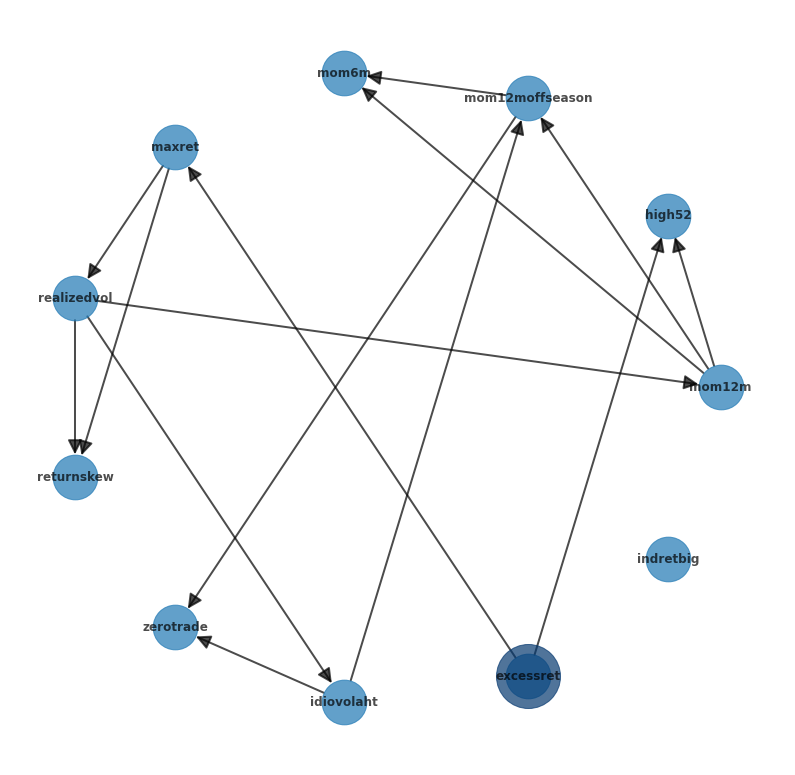

In [ ]:
# plotting the graph
plt.figure(3,figsize=(14,14))
G = nx.DiGraph()
G.add_edges_from(model.edges)

G.add_nodes_from(model.nodes)
pos = nx.circular_layout(G)
DAG = G.to_directed()
nx.topological_sort(DAG)
nx.draw_networkx(G,
                pos=pos,
                with_labels=True,
                node_size=2000,
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)

tt_g = G.subgraph(nodes=['excessret'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color="#063970")

plt.show()

In [ ]:
# cpts tables
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
  print(f'CPT of {cpd.variable}:')
  print(cpd * 100, '\n')

Check model: True

CPT of high52:
+------------+--------------------+-----+---------------------+
| excessret  | excessret(Q1)      | ... | excessret(Q4)       |
+------------+--------------------+-----+---------------------+
| mom12m     | mom12m(Q1)         | ... | mom12m(Q4)          |
+------------+--------------------+-----+---------------------+
| high52(Q1) | 98.23943661971832  | ... | 0.40453074433656955 |
+------------+--------------------+-----+---------------------+
| high52(Q2) | 0.5868544600938966 | ... | 0.40453074433656955 |
+------------+--------------------+-----+---------------------+
| high52(Q3) | 0.5868544600938966 | ... | 5.582524271844661   |
+------------+--------------------+-----+---------------------+
| high52(Q4) | 0.5868544600938966 | ... | 93.6084142394822    |
+------------+--------------------+-----+---------------------+ 

CPT of mom12m:
+-------------+--------------------+-----+--------------------+
| realizedvol | realizedvol(Q1)    | ... | realizedvo

In [ ]:
# scoring the model
accuracy_dict = {}

for column in testing_data:
  predict_data = testing_data.copy()
  predict_data.drop(column, axis=1, inplace=True)
  y_pred=model.predict(predict_data)

  accuracy = accuracy_score(testing_data[column], y_pred)
  print(f'{column} Accuracy score: {accuracy}')
  accuracy_dict[column] = accuracy

  0%|          | 0/100 [00:00<?, ?it/s]

high52 Accuracy score: 0.63


  0%|          | 0/100 [00:00<?, ?it/s]

mom12m Accuracy score: 0.74


  0%|          | 0/100 [00:00<?, ?it/s]

mom6m Accuracy score: 0.51


  0%|          | 0/100 [00:00<?, ?it/s]

maxret Accuracy score: 0.68


  0%|          | 0/100 [00:00<?, ?it/s]

mom12moffseason Accuracy score: 0.57


  0%|          | 0/100 [00:00<?, ?it/s]

realizedvol Accuracy score: 0.69


  0%|          | 0/100 [00:00<?, ?it/s]

idiovolaht Accuracy score: 0.56


  0%|          | 0/100 [00:00<?, ?it/s]

zerotrade Accuracy score: 0.31


  0%|          | 0/100 [00:00<?, ?it/s]

indretbig Accuracy score: 0.18


  0%|          | 0/100 [00:00<?, ?it/s]

returnskew Accuracy score: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

excessret Accuracy score: 0.47


In [ ]:
# scoring the model continued
f1 = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=testing_data)
ss = structure_score(model=model, data=testing_data, scoring_method='bdeu')

print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likelihood score: {ls}')
print(f'Structure score: {ss}')

F1 score: 0.5714285714285715
Accuracy score: 0.7272727272727273
Precision score: 1.0
Recall score: 0.4
Log-likelihood score: -1268.129300975743
Structure score: -1467.525558957718


### Write your description in the following

I decided to use Bayesian Network in this analysis, as it is a good choice to spot the probabilistic relationships between 'defined features' and a firm's excess returns (target variable). Bayesian Networks are particularly good for this task due to their ability to capture complex dependencies.

In the created network, 'high52' and 'maxret' show as the attributes with the highest correlation to the target variable, indicating these factors are potentially strong predictors of excess returns. This insight is valuable for financial analysis and investment strategy formulation.

The model's performance, with an accuracy of 0.72 and perfect precision (1.0), indicates it is reliable in its predictions. However, the opportunity to improve the F1 score suggests that future iterations could enhance the model's ability to identify all relevant cases.

For visualization, a graph from the Bayesian Network can show the strength of the connections, with the edges between 'high52', 'maxret', and 'excessret' being highlighted to reflect their importance. This visual tool effectively communicates the probabilistic relationships and the model's findings in a concise and interpretable manner.